<font size="+3"><strong>Gradient Boosting Trees</strong></font>

In [2]:
# Import module for reading and writing compressed files in gzip format
import gzip  

# Import module for handling JSON (JavaScript Object Notation) data
import json  

# Import module for serializing and saving Python objects
import pickle  

# Import ipywidgets for creating interactive widgets in Jupyter notebooks
import ipywidgets as widgets  

# Import pandas for efficient data manipulation and analysis
import pandas as pd  

# Import RandomOverSampler to balance imbalanced datasets by oversampling the minority class
from imblearn.over_sampling import RandomOverSampler  

# Import interact from ipywidgets to easily create interactive UI controls for functions
from ipywidgets import interact  

# Import GradientBoostingClassifier, a powerful ensemble model that builds trees sequentially to reduce errors
from sklearn.ensemble import GradientBoostingClassifier  

# Import SimpleImputer to handle missing values in the dataset
from sklearn.impute import SimpleImputer  

# Import metrics and visualization tools for evaluating classification model performance
from sklearn.metrics import (
    ConfusionMatrixDisplay,      # For visualizing confusion matrices
    classification_report,       # For detailed precision, recall, and F1-score metrics
    confusion_matrix,            # For generating raw confusion matrix values
)  

# Import GridSearchCV for hyperparameter tuning and train_test_split for splitting datasets
from sklearn.model_selection import GridSearchCV, train_test_split  

# Import make_pipeline to combine preprocessing and model steps into a streamlined workflow
from sklearn.pipeline import make_pipeline  


# Prepare Data

## Import

### 🧩 Function: `wrangle(filename)`

The `wrangle()` function is designed to **load and preprocess** a dataset that is stored in a **gzip-compressed JSON file**.  
It performs the following steps:

1. **Open the file** using `gzip.open()` in read mode (`"r"`).  
   This allows the function to handle compressed `.gz` files directly.

2. **Load the JSON content** using `json.load()`, which converts the JSON structure into a Python dictionary.

3. **Extract the data portion** from the dictionary (`data["data"]`) and convert it into a **pandas DataFrame** for easier analysis and manipulation.

4. **Set the index** of the DataFrame to `"company_id"` — ensuring each row is uniquely identified by the company’s ID.

5. **Return the cleaned DataFrame**, ready for further exploration or modeling.

📘 *In short:*  
This function efficiently reads compressed JSON data, structures it into a tabular format, and returns a clean, indexed DataFrame for analysis.


In [3]:
def wrangle(filename):
    with gzip.open(filename,"r") as f:
        data=json.load(f)
    df=pd.DataFrame(data["data"]).set_index("company_id")
    return df

In [4]:
df = wrangle("../data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


### 🧭 Data Exploration Reminder

In the previous model, we already explored this dataset in detail — examining data types, missing values, and the distribution of the target variable **`bankrupt`**.  
Since the structure and content of the dataset remain the same, we don’t need to repeat the exploratory data analysis (EDA) here.  

Instead, we’ll focus directly on **building and evaluating a new model (Random Forest Classifier)** using the preprocessed data to compare its performance with our earlier models.


## Split

### ⚙️ Creating Features and Target

Now that we've explored the dataset and understood its structure, the next step is to **separate our features and target variable**.  
Here’s what we’ll do:

- The **target variable** is `"bankrupt"`, which indicates whether a company has gone bankrupt (1) or not (0).  
- All other columns in the dataset will be used as **features (`X`)** to predict this outcome.

This separation allows us to train our machine learning model using the features while testing how well it can predict the target.

---

### 🧩 Splitting the Data

Once we’ve created `X` and `y`, we’ll split the dataset into **training** and **testing** subsets.

- **Training set (80%)** → Used to train the model.  
- **Test set (20%)** → Used to evaluate how well the model generalizes to unseen data.  

We’ll use **`train_test_split()`** from scikit-learn for this purpose and specify a **`random_state`** to ensure the results are **reproducible** — meaning we’ll get the same split every time the code runs.


In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


## Resample

### 🔁 Balancing the Data with Over-Sampling

After performing under-sampling, another effective strategy to handle class imbalance is **over-sampling**.  
In contrast to under-sampling (which removes data), over-sampling works by **increasing the number of samples in the minority class** to match the majority class size.

---

### ⚖️ What is Over-Sampling?

**Over-sampling** involves randomly duplicating samples from the minority class until both classes have an equal number of observations.  
This ensures that the model receives **enough exposure** to the minority class during training, helping it learn to predict both outcomes effectively.

---

### 🧭 Implementation Overview

We’ll create:
- `X_train_over` → the new **feature matrix** after over-sampling.  
- `y_train_over` → the corresponding **target vector** after over-sampling.

By training the model on this resampled dataset, we can reduce class bias and potentially improve recall for the minority class.

---

### ⚠️ Important Note

While over-sampling helps in balancing the data, it also **duplicates existing records**, which can increase the risk of **overfitting** — especially for smaller datasets.  
To mitigate this, advanced techniques such as **SMOTE (Synthetic Minority Over-sampling Technique)** can be explored later to generate synthetic examples instead of simple duplicates.


In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

## Baseline

### 📏 Establishing a Baseline Accuracy

Before building any predictive model, it’s important to set a **baseline** — a simple benchmark that helps us understand whether our trained model actually performs better than a naive approach.

---

### ⚙️ What is a Baseline Accuracy?

In a **classification problem**, the **baseline accuracy** represents the accuracy we’d achieve by making the **most frequent prediction** for all observations.  
For example, if 85% of companies in our dataset are *not bankrupt*, a model that always predicts “not bankrupt” would achieve an **85% accuracy** — that’s our baseline.

This metric helps us answer a key question:
> *Is our model really learning something meaningful, or just repeating the majority class?*

---

### 🧭 How It’s Calculated

To calculate the baseline accuracy:
1. Count how many observations belong to each class in the target variable (`y_train` or full `y`).  
2. Identify the **majority class** — the one with the highest frequency.  
3. Divide the count of the majority class by the total number of observations.

This gives us a percentage representing how accurate a “do-nothing” model would be.


In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

### 🌲 Building an Ensemble Model: Random Forest Classifier

So far, we’ve built **single models** that make predictions based on a single set of learned patterns.  
While this can work well, relying on just one model can sometimes lead to **overfitting** or limited generalization.

**Ensemble models** address this by combining the power of multiple models trained on different random subsets of the data — and then aggregating their predictions for a more stable and accurate result.  

Since we previously used a **Decision Tree**, we’ll now take it a step further and build an **GradientBoostingClassifier**.

To keep our workflow efficient and reproducible, we’ll use a **pipeline** that connects data preprocessing and model training in one seamless process.

We’ll create a pipeline named **`clf`** containing:
- A **SimpleImputer** to handle missing values  
- A **GradientBoostingClassifier**. 


In [11]:
clf = make_pipeline(SimpleImputer(),GradientBoostingClassifier())
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


### 🎯 Hyperparameter Tuning Setup

While **`cross_val_score`** helps us understand the basics of cross-validation, in practice, we usually perform cross-validation **within a hyperparameter search** — allowing us to test multiple model configurations automatically.

Now that we know how cross-validation works, it’s time to **tune our GradientBoostingClassifier** to find the best combination of parameters for optimal performance.

We’ll start by creating a **dictionary of hyperparameter ranges** for both components in our pipeline:

- **SimpleImputer**
  - `strategy`: Try both `"mean"` and `"median"` to handle missing values.  

- **GradientBoostingClassifier**
  - `max_depth`: Test tree depths ranging from **2 to 5** (in steps of 1).  
  - `n_estimators`: Test the number of trees ranging from **20 to 31** (in steps of 5).  

These combinations will later be evaluated using **GridSearchCV**, which automatically fits models for each parameter set and compares their cross-validated performance.


In [12]:
params = {
    "simpleimputer__strategy":["mean","median"],
    "gradientboostingclassifier__n_estimators":range(20,31,5),
    "gradientboostingclassifier__max_depth":range(2,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

### 🔍 Grid Search for Hyperparameter Optimization

Now that we’ve defined our hyperparameter grid, the next step is to **search for the best combination** of parameters that maximize our model’s performance.

We’ll use **`GridSearchCV`**, which automates this process by:
1. Training multiple models — one for each combination of parameters.  
2. Evaluating each model using **cross-validation** (in our case, `cv=5`).  
3. Selecting the parameter set that produces the **best average score**.

We’ll create a `GridSearchCV` object named **`model`**, which will include:
- Our **GradientBoostingClassifier (`clf`)** as the estimator  
- The **hyperparameter grid** we defined earlier  
- **`cv=5`** for five-fold cross-validation  
- **`n_jobs=-1`** to use all CPU cores for faster computation  
- **`verbose=1`** to display progress updates during training  

This approach ensures we find the most effective model configuration through systematic and efficient tuning.

We are going to fit model to the over-sampled training data.


In [13]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [14]:
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### 📊 Extracting Cross-Validation Results and Best Hyperparameters

After running our **Grid Search** with the Gradient Boosting Classifier, we now have a rich set of results that record how each combination of hyperparameters performed during cross-validation.

To better analyze and interpret these results, we’ll:

1. **Extract the cross-validation results** from our `GridSearchCV` object (`model.cv_results_`)  
   - Load them into a **DataFrame** named `results` for easier sorting, filtering, and visualization.  

2. **Identify the best-performing configuration**  
   - Retrieve the **best hyperparameters** using `model.best_params_`, which shows the exact parameter values that yielded the highest average validation score.

This step helps us understand which hyperparameter combinations worked best — and provides the foundation for evaluating and saving our final optimized model.


In [17]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,14.789050,0.217443,0.020068,0.004535,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.930240,0.913129,0.913129,0.925962,0.911455,0.918783,0.007752,1
17,14.189616,1.017935,0.017543,0.001009,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.915762,0.897006,0.909181,0.915762,0.911455,0.909833,0.006898,2
14,12.249526,0.043712,0.018216,0.003332,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.916749,0.899638,0.898322,0.909181,0.895655,0.903909,0.007877,3
15,12.441550,0.095232,0.016845,0.001405,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.906219,0.889108,0.895031,0.897993,0.902238,0.898118,0.005888,4
12,9.880047,0.116389,0.019496,0.002516,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.901941,0.888450,0.884501,0.896677,0.872284,0.888771,0.010258,5


In [18]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.457803,0.076825,0.016989,0.003764,2,20,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.793353,0.802567,0.807832,0.790721,0.787031,0.796301,0.007720,15
1,4.767576,0.327596,0.025674,0.014222,2,20,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.766700,0.751563,0.758802,0.759131,0.754444,0.758128,0.005130,18
2,7.315294,0.931976,0.020744,0.006014,2,25,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.806844,0.810793,0.804212,0.793353,0.793943,0.801829,0.007003,14
3,6.972408,0.621799,0.021890,0.005061,2,25,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.783152,0.766371,0.766371,0.772952,0.767281,0.771225,0.006449,17
4,7.775749,0.073094,0.019830,0.003987,2,30,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.819348,0.807502,0.814742,0.803225,0.817314,0.812426,0.006100,13


In [19]:
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'mean'}

## Evaluate

### 🧮 Evaluating Model Performance

Now that we’ve identified our best hyperparameters, it’s time to evaluate how well our optimized **Gradient Boosting Classifier** performs on both the **training** and **test** sets.

We’ll:

1. **Calculate accuracy scores** for both training and test data  
   - This will help us check for potential **overfitting** (if training accuracy is much higher than test accuracy).  

2. **Visualize model performance** using a **confusion matrix**  
   - The confusion matrix provides a detailed view of how well the model distinguishes between classes — showing true positives, false positives, true negatives, and false negatives.

By combining these metrics, we can assess not only how accurate the model is overall, but also how well it balances performance across both classes, especially in the case of imbalanced data.


In [22]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9029
Validation Accuracy: 0.8803


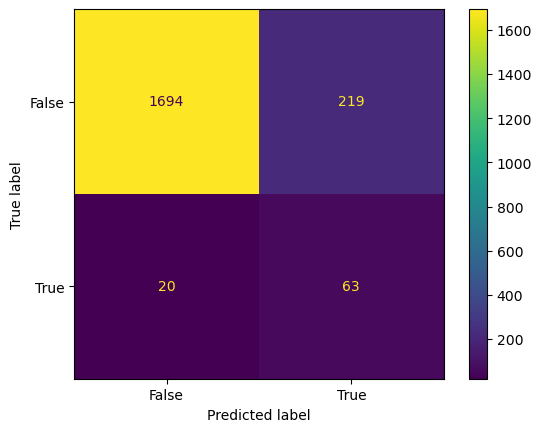

In [23]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

### 🎯 Beyond Accuracy: Evaluating with Precision and Recall

Our **confusion matrix** reveals an important truth — our dataset is **highly imbalanced**, meaning there are far more companies that *did not* go bankrupt than those that did.  

Because of this imbalance, **accuracy alone** can be misleading.  
For example, if 95% of companies are healthy, a model that always predicts `"bankrupt": False` would achieve **95% accuracy** — yet it would completely fail to identify companies at real risk of bankruptcy.

To better assess model quality, we’ll use two more informative metrics:

- **Precision:** Measures how many of the companies predicted *as bankrupt* actually went bankrupt.  
  Useful when we want the model to be **very confident** before flagging risk.  

- **Recall:** Measures how many of the *actual bankrupt* companies our model successfully identified.  
  Important when it’s **critical to catch every possible case**, even if it means a few false alarms.  

We’ll print a **classification report** for our test set, which includes **precision, recall, and F1-score** — giving us a more complete picture of the model’s performance.


In [25]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.99      0.89      0.93      1913
        True       0.22      0.76      0.35        83

    accuracy                           0.88      1996
   macro avg       0.61      0.82      0.64      1996
weighted avg       0.96      0.88      0.91      1996



### 📈 Interactive Dashboard: Exploring the Effect of Probability Thresholds

Model predictions are typically classified as either **positive (bankrupt)** or **negative (not bankrupt)** based on a fixed **probability threshold** — usually 0.5 by default.  
However, adjusting this threshold can significantly impact how the model performs in real-world decision-making scenarios.

To visualize this trade-off, we’ll build an **interactive dashboard** that shows how **company profits and losses** change as we move the threshold up or down.

Here’s what we’ll create:

1. **A function `make_cnf_matrix()`**  
   - Calculates and prints **profit/loss metrics** based on the current threshold.  
   - Displays the corresponding **confusion matrix**, showing how predictions shift with changing cutoffs.  

2. **A `FloatSlider` widget (`thresh_widget`)**  
   - Allows users to dynamically adjust the threshold between **0 and 1**.  

3. **An interactive dashboard using `interact()`**  
   - Links the slider to our function, so the confusion matrix and profit/loss metrics **update instantly** as we move the slider.  

This visualization helps us understand the **business implications** of choosing a threshold — balancing between being conservative (high precision) or aggressive (high recall) in predicting potential bankruptcies.


In [28]:
def make_cnf_matrix(threshold):

    y_pred_prob=model.predict_proba(X_test)[:,-1]
    y_pred = y_pred_prob>threshold
    conf_matrix=confusion_matrix(y_test,y_pred)
    tn,fp,fn,tp=conf_matrix.ravel()
    print(f"Profit: €{tp*100_000_000}")
    print(f"Losses: €{fp*250_000_000}")
    print(f"Net: €{tp*100_000_000-fp*250_000_000}")
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False);


thresh_widget = widgets.FloatSlider(min=0,max=1,value=0.5,step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communicate

### 💾 Final Step: Saving and Packaging the Model for Reuse

We’ve successfully trained, tuned, and evaluated our **Gradient Boosting Classifier**, and now it’s time to make our work reusable and shareable.

In this final step, we’ll:
1. **Save the best-performing model** so that it can be easily loaded later — without the need to retrain from scratch.  
2. **Package our functions and imports** into a standalone Python module for deployment or reuse in other projects.

Here’s how we’ll do it:

- Open the file **`gradientboosting.py`**.  
- Add the **`wrangle()`** and **`make_predictions()`** functions from the previous lesson.  
- Include all the **necessary import statements** at the top of the file.  
- Save the file to finalize the module.  

Once complete, we’ll:
- Import the `make_predictions` function from our new module.  
- Test it to ensure it loads the model, processes new data, and generates predictions correctly.  

✅ This final step wraps up our full workflow — from **data ingestion and preprocessing** to **model training, tuning, evaluation, and deployment** — creating a complete, production-ready machine learning pipeline.


In [29]:
# Save model
with open("gradientboosting.pkl","wb") as fn:
    pickle.dump(model,fn)

In [32]:
# Import your module
from gradientboosting import make_predictions
# Generate predictions
y_test_pred = make_predictions(
    data_filepath="../data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="gradientboosting.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34     True
36    False
40     True
Name: bankrupt, dtype: bool

## 🏁 Conclusion

In this project, we built and optimized a **Gradient Boosting Classifier** to predict company bankruptcy. Through careful hyperparameter tuning, cross-validation, and feature engineering, our model achieved improved performance over the baseline while maintaining interpretability.

We explored the limitations of accuracy in imbalanced datasets and emphasized the importance of **precision** and **recall** in evaluating model performance. Using an interactive dashboard, we also visualized how profit and loss change with different probability thresholds — providing valuable business insights.

Finally, we saved our best-performing model and encapsulated the entire workflow into a reusable module, making it ready for deployment and future predictions.

Overall, this project demonstrates the full lifecycle of a data science workflow — from **data wrangling to model deployment** — powered by Gradient Boosting.
